In [5]:
%load_ext autoreload
import glob
import nibabel 
import nilearn
import pandas as pd
import numpy as np
import h5py
import json
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm
from joblib import Parallel, delayed
import logging
from IPython.core.debugger import set_trace
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import re
import os
import shutil
import pickle
import torchio

import torch
import torch.nn.functional as F

from utils import create_dicts, normalize, load, video, video_comparison

from multiprocessing import cpu_count
N_CPU = cpu_count()

from IPython.core.display import display, HTML
from celluloid import Camera

SEED = 42
%autoreload 2
DEVICE = 'cuda:1'
device = torch.device(DEVICE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
!nvidia-smi

Wed Jun  1 17:54:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 55%   83C    P2   164W / 250W |   9900MiB / 12211MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   

In [7]:
# labels_components = np.load('metadata/label_info.npy', allow_pickle=True).item()
# nonsingle_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) != 2}

# labels_broken = {'55','54', '47','43','37','33','25','12', '9','6','3','70NS','73NS', '73NS',
#                   'n42', 'n83', 'n30', 'n27', 'n31', 'n20', 'n10', 'n8', 'n3'
#                  }.union(nonsingle_component_keys)

# len(labels_broken)

# Create paths dicts

for each label associated with subject there will be a dict of paths for different features

### Yarkin data

In [8]:
brain = nibabel.load('/media/tom/ibulygin/fcd_data/yarkin_data/brain/FCD_1_1_t1.nii.gz').get_fdata()

In [9]:
plt.ioff()
camera = video(brain, 
               n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [14]:
root = '/media/tom/ibulygin/fcd_data/yarkin_data/'
root_label = os.path.join(root, 'lesion_labels')

feature_paths_templates = {
      'label':os.path.join(root, 'lesion_labels/FCD_{label}_1_lesion.nii.gz'),
      'T1': os.path.join(root, 'brain/FCD_{label}_1_t1.nii.gz'),
      'Flair': os.path.join(root, 'brain/FCD_{label}_1_flair.nii.gz'),
    }

label_extractor = lambda x: x.split('_')[1]

paths_dict = create_dicts(root_label,
                         feature_paths_templates,
                         label_extractor=label_extractor,
                         broken_labels=None) 

features = ['T1', 'Flair']

In [15]:
len(paths_dict)

185

In [16]:
with open('/media/tom/ibulygin/fcd_data/yarkin_data/train_list.json') as f:
    train_labels = [label_extractor(p) for p in json.load(f)]
    
with open('/media/tom/ibulygin/fcd_data/yarkin_data/test_list.json') as f:
    test_labels = [label_extractor(p) for p in json.load(f)]

In [17]:
keys_all = train_labels + test_labels

In [39]:
metadata = {'train':train_labels,
            'test':test_labels}
np.save('metadata/metadata_yarkin_data.npy', metadata)

### Brats

In [19]:
# root = '/media/tom/ibulygin/MICCAI_BraTS2020_TrainingData/'

# feature_paths_templates = {
#       'seg':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_seg.nii.gz'),
#       't1':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_t1.nii.gz'),
#       't1ce':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_t1ce.nii.gz'),
#       't2':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_t2.nii.gz'),
#       'flair':os.path.join(root, 'BraTS20_Training_{label}/BraTS20_Training_{label}_flair.nii.gz'),
#     }

### MNI152 (preprocessed)

In [50]:
# pirogov_labels = set(filter(lambda x: len(re.findall('^\d+',x)) > 0 , labels_components.keys()))
# labels_broken = labels_broken.union(pirogov_labels)

In [51]:
# root = '/media/tom/ibulygin/fcd_data/radiologist/'
# root_label = os.path.join(root, 'label')

# feature_paths_templates = {
#       'label':os.path.join(root, 'label/{label}.nii.gz'),
#       'mask':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
#       'curv':os.path.join(root, 'curv/norm-{label}.nii.gz'),
#       'sulc':os.path.join(root, 'sulc/norm-{label}.nii.gz'),
#       'thickness':os.path.join(root, 'thickness/norm-{label}.nii.gz'),
#       'bT1': os.path.join(root, 'fmriprep/sub-{label}/anat/n_blurring-in-volume.nii.gz'),
# #       'bT1':[os.path.join(root, 'bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz'), # non-norm
# #             os.path.join(root, 'fmriprep/sub-{label}/anat/n_blurring-in-volume.nii.gz')], # norm?
#       'bT2':os.path.join(root, 'bluring-T2/sub-{label}_T2blurring-in-volume.nii.gz'), # non-norm!
#       'T1w':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'),
# #       'flair':os.path.join(root, 'Flair/sub-{label}.nii.gz'),
# #       'T2':os.path.join(root, 'T2/{label}.nii'),
#       'CSF':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'),
#       'GM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-GM_probseg.nii.gz'),
#       'WM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-WM_probseg.nii.gz'),
#       'entropy':os.path.join(root, 'entropy/n_sub-{label}_entropy.nii.gz'),
#       'cr':os.path.join(root, 'fmriprep/sub-{label}/anat/*n_T2_CR-{label}.nii.gz')
#     }

# paths_dict = create_dicts(root_label,
#                          feature_paths_templates,
#                          label_extractor=lambda x: x.split('.')[0],
#                          broken_labels=labels_broken) 

In [52]:
# features = set(feature_paths_templates.keys()) - {'label'}

# len(paths_dict)

In [53]:
# datas = {}
# for k in tqdm(keys_all):
#     datas[k] = load(paths_dict[k])
#     datas[k]['mask'] = datas[k]['T1'] > 0

In [54]:
# data = datas[keys_all[0]]
# plt.ioff()
# camera = video_comparison([data['T1'], data['Flair'], data['label'], data['T1'] > 0], 
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [55]:
# features_min = defaultdict(list)
# features_max = defaultdict(list)

# for k,data in tqdm(datas.items()):
#     mask = data['mask'] > 0
#     for f,v in data.items():
#         features_min[f].append(v[mask].min())
#         features_max[f].append(v[mask].max())        

In [56]:
# plt.ion()
# for f in features_min.keys():
#     fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(10,5))
    
#     axes[0].hist(features_min[f], bins=50)
#     axes[0].set_yscale('log')
#     axes[0].set_title('Min dist')
    
#     axes[1].hist(features_max[f], bins=50)
#     axes[1].set_yscale('log')
#     axes[1].set_title('Max dist')
    
#     fig.suptitle(f) 
# plt.show()

# Visualize different features mean over coronal axis 

In [20]:
def percentile_clip(featuremap, mask):
    
    '''
    mask - binary
    '''
    
    values = featuremap[mask]
    v_min =  np.percentile(values, 0.01), 
    v_max = np.percentile(values, 99.9)
    featuremap[mask] = np.clip(values, v_min, v_max)
    
    return featuremap

In [58]:
# n_labels_vis = 10

# features_subsample = defaultdict(dict)
# features_hist = defaultdict(dict)

# random_labels = np.random.choice(list(paths_dict.keys()), size=n_labels_vis, replace=False)

# for label in random_labels:
#     mask_path = paths_dict[label]['mask']
#     mask = nibabel.load(mask_path).get_fdata()
    
#     for feature_name in tqdm(features):
#         path = paths_dict[label][feature_name]
        
#         featuremap = nibabel.load(path).get_fdata() * mask
        
#         featuremap = percentile_clip(featuremap, mask > 0)
        
#         features_subsample[label][feature_name] = featuremap.mean(-2)
#         features_hist[label][feature_name] = np.histogram(featuremap[mask > 0], bins=100)

In [59]:
# fig, axes = plt.subplots(nrows=n_labels_vis, ncols=len(features), 
#                          dpi=200, sharex=True, sharey=True, figsize=(10,10))

# for i,label in enumerate(random_labels):
#     for j,feature_name in enumerate(features):
        
#         f_mean = features_subsample[label][feature_name]
        
#         axes[i,j].imshow(f_mean)
#         axes[i,j].set_title(f'{label}-{feature_name}', fontsize=10)
        
# plt.tight_layout()
                
# plt.show()

In [60]:
# plt.bar(features_hist[label][feature_name][1][1:],
#                             features_hist[label][feature_name][0], width=0.01)
# plt.show()

In [61]:
# fig, axes = plt.subplots(nrows=len(random_labels), ncols=len(features), 
#                          dpi=200, figsize=(50,20)) 

# for i,label in enumerate(random_labels):
#     for j,feature_name in enumerate(features):
        
#         axes[i,j].bar(features_hist[label][feature_name][1][1:],
#                             features_hist[label][feature_name][0], width=0.1)
#         axes[i,j].set_title(f'{label}-{feature_name}', fontsize=10)
#         axes[i,j].set_yscale('log')

# plt.tight_layout()
                
# plt.show()

# Create tensors

In [21]:
def make_tensor(root, name, pdict, save=True, Log=print, gen_mask_from=None, normalize_data=True):
        
    if save:
        filename = os.path.join(root, f'tensor_{name}')
        if os.path.exists(filename):
            try:
                torch.load(filename)
                Log(f'Tensor found: {name}')
                return None
            except:
                Log(f'tensor was not loaded, recalculating: {name}')
                os.remove(filename)
                
    try:
        data_dict = load(pdict)
        Log(f'pdict was loaded, calculating...: {name}')
    except:
        Log(f'pdict was not loaded, skipping...: {name}')
        return None
    
    ################
    # MAKE TENSORS #
    ################
    
    if not hasattr(data_dict, 'mask'):
        mask = data_dict[gen_mask_from] > 0
    else:
        mask = data_dict['mask'] > 0 # it should be bool!

    label = (data_dict['label'] > 1e-10).astype(int)
    
    assert label.sum() < mask.sum()
    
    # add .transpose(2,1,0) - for original labels 
    label = label * mask.astype(int) 
    
    mask_tensor_torch = torch.tensor(mask, dtype=torch.float32)
    label_tensor_torch = torch.tensor(label, dtype=torch.float32)
    
    torch_tensor = {'mask':mask_tensor_torch,
                    'label':label_tensor_torch}
    
    for k,v in data_dict.items():
        if not k in ['mask', 'label']:
            v = percentile_clip(v, mask)
            if normalize_data:
                data = normalize(v, mask) # zero background, normalize in `mask` region
            else:
                data = v * mask
                
            data_torch = torch.tensor(data, dtype=torch.float32)
            torch_tensor[k] = data_torch
    if save:
        torch.save(torch_tensor, filename, _use_new_zipfile_serialization=False)
        
    Log(f'Calculated: {name}')
    
    return torch_tensor

### Check that created tensor is valid

In [22]:
%%time
tensor = make_tensor('./', 'n32', paths_dict['n32'], save=False, gen_mask_from='T1', normalize_data=False)

pdict was loaded, calculating...: n32
Calculated: n32
CPU times: user 8.62 s, sys: 568 ms, total: 9.19 s
Wall time: 1.62 s


In [23]:
# for k,v in paths_dict.items():
#     data_dict = load(v)
#     print(k, data_dict['label'].shape, data_dict['T1w'].shape)

In [24]:
for k,v in tensor.items():
    print(k,v.shape, v.max(), v.min())

mask torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
label torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
T1 torch.Size([197, 233, 189]) tensor(487.8947) tensor(0.)
Flair torch.Size([197, 233, 189]) tensor(468.8447) tensor(0.)


In [25]:
# plt.ioff()
# camera = video_comparison([t.numpy() for t in tensor.values()],
#                           n_slides=128)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [54]:
128/(2**3)

16.0

### Creating tensors

In [35]:
tensors_root = '/media/tom/ibulygin/fcd_data/tensors_yarkin_data/'

In [36]:
if not os.path.exists(tensors_root):
    os.makedirs(tensors_root)

In [37]:
len(paths_dict)

185

In [30]:
logfile = 'make_tensor.log'
if os.path.isfile(logfile):
    os.remove(logfile)

logger = logging.getLogger('make_tensor')
logger.addHandler(logging.FileHandler(logfile))

_ = Parallel(n_jobs=N_CPU//4)(delayed(make_tensor)(tensors_root, 
                                                   k, 
                                                   paths_dict[k], 
                                                   save=True, 
                                                   Log=logger.warning,
                                                   gen_mask_from='T1',
                                                   normalize_data=True) \
                              for k in tqdm(keys_all))

 15%|████████████████████▎                                                                                                                   | 10/67 [00:00<00:02, 26.97it/s]pdict was loaded, calculating...: 18
pdict was loaded, calculating...: 22
pdict was loaded, calculating...: 55
pdict was loaded, calculating...: 83
pdict was loaded, calculating...: 39
pdict was loaded, calculating...: 53
pdict was loaded, calculating...: 57
pdict was loaded, calculating...: 26
pdict was loaded, calculating...: 30
pdict was loaded, calculating...: 43
Calculated: 53
 30%|████████████████████████████████████████▌                                                                                               | 20/67 [00:11<00:30,  1.53it/s]Calculated: 18
Calculated: 83
Calculated: 26
Calculated: 39
Calculated: 30
pdict was loaded, calculating...: 33
Calculated: 55
Calculated: 57
Calculated: 22
Calculated: 43
pdict was loaded, calculating...: 54
Calculated: 33
pdict was loaded, calculating...: 76
pdict wa

# Visualize

In [46]:
for i,tensor_name in enumerate(os.listdir(tensors_root)):
    tensor_dict = torch.load(os.path.join(tensors_root, tensor_name))
    for k,v in tensor_dict.items():
        print(k, v.shape, v.max(), v.min())

mask torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
label torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
T1 torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
Flair torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
mask torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
label torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
T1 torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
Flair torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
mask torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
label torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
T1 torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
Flair torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
mask torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
label torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
T1 torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
Flair torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
mask torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
label torch.Size([197, 233, 189]) tensor(1.) tensor(0.)
T1 torch.

KeyboardInterrupt: 

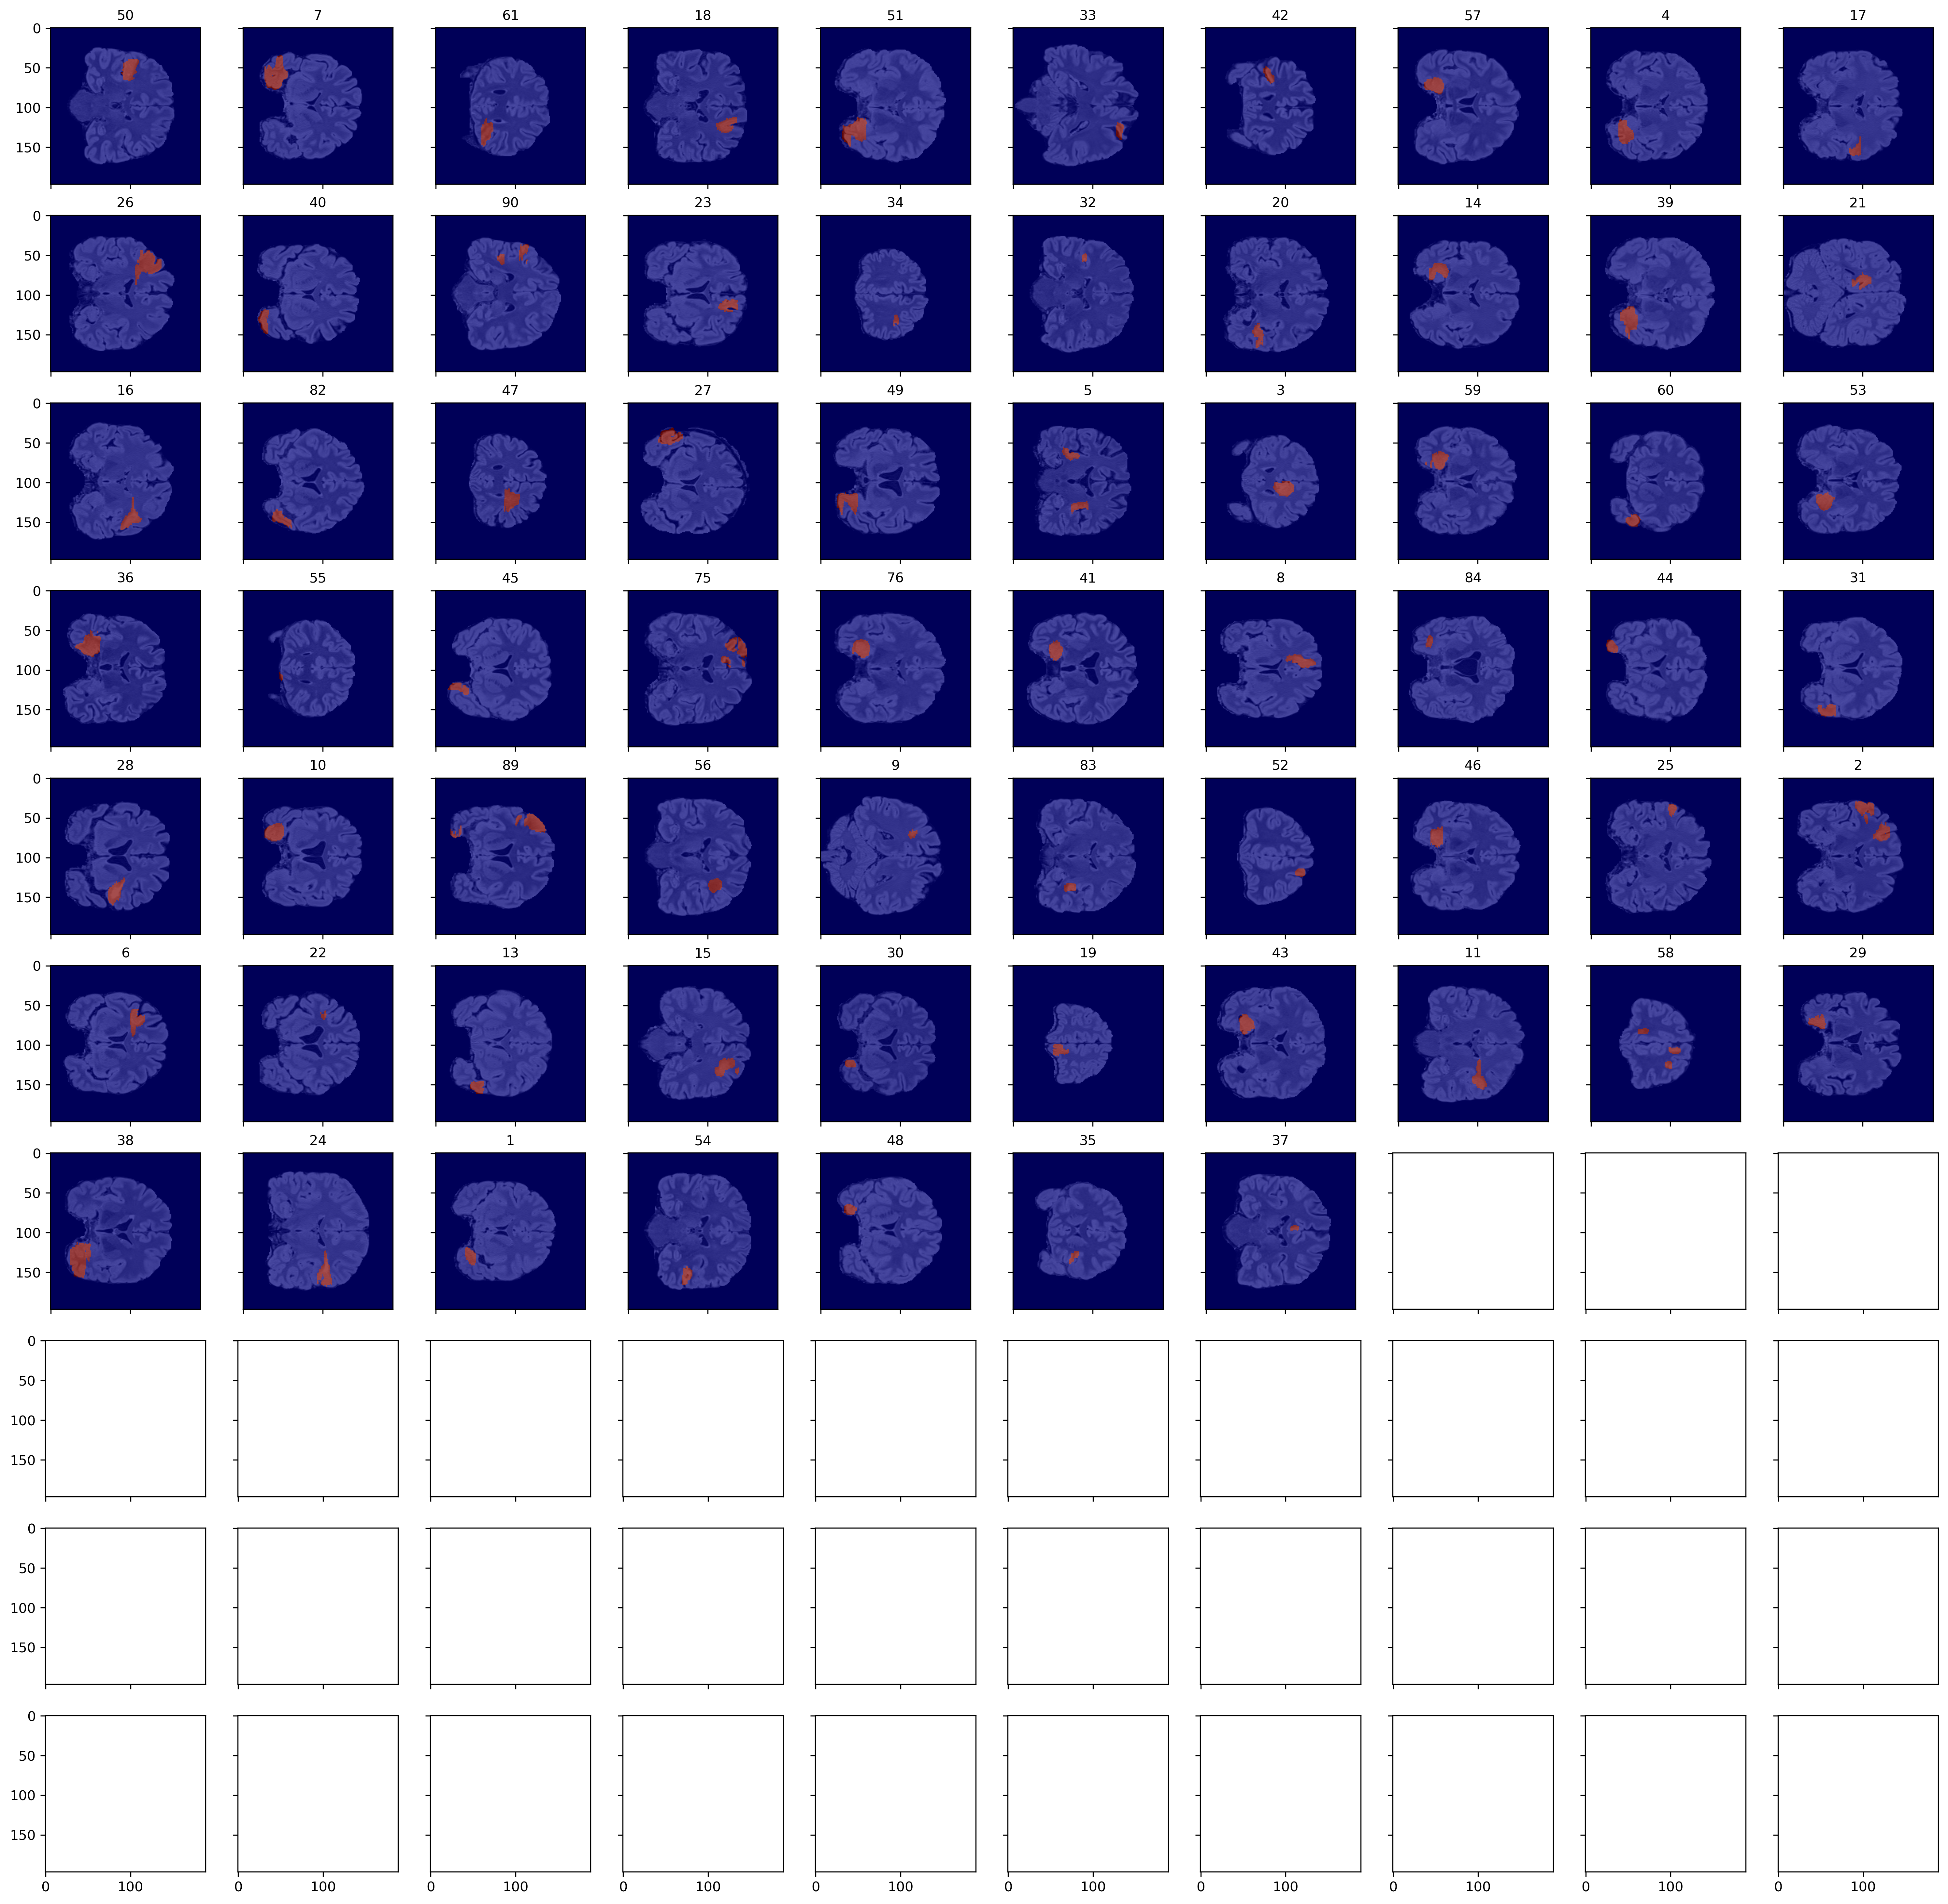

In [45]:
plt.ion()

fig, axes = plt.subplots(ncols=10, nrows=10, 
                         sharex=True, sharey=True, dpi=300, figsize=(25,25))
for i,tensor_name in enumerate(os.listdir(tensors_root)):
    
    tensor_dict = torch.load(os.path.join(tensors_root, tensor_name))
    
    mask_tensor = tensor_dict['mask']
    label_tensor = tensor_dict['label']*mask_tensor
    brain_tensor = tensor_dict['Flair']*mask_tensor

    y_split = label_tensor.sum(dim=(0,-1)).argmax()

    brain_tensor_split = brain_tensor[:,y_split,:].numpy()
    label_tensor_split = label_tensor[:,y_split,:].numpy()
    
    ax = axes.flatten()[i]
    
    key = tensor_name.split('_')[1]
    ax.imshow(brain_tensor_split, 'gray')
    ax.imshow(label_tensor_split, 'jet', interpolation='none', alpha=0.7)
    
    ax.set_title(key, fontsize=10)
    
plt.show()

In [47]:
label_tensor

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

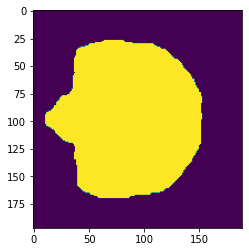

In [42]:
plt.imshow(mask_tensor[:,y_split,:])

In [38]:
brain_tensor.max()

tensor(1.)

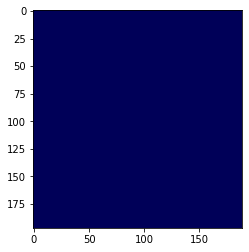

In [32]:
suspicious_labels = ['1', '43', '30', '44', '52', '3', '16', '68NS' ,'27', '47', '23']

label_s = suspicious_labels[0]


tensor_name = f'tensor_{label_s}'
tensor_dict = torch.load(os.path.join(tensors_root, tensor_name))

mask_tensor = tensor_dict['mask']
label_tensor = tensor_dict['label']
brain_tensor = tensor_dict['T1']*mask_tensor

plt.ioff()
camera = video(brain_tensor, 
               label_tensor,
               n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [34]:
# for s in suspicious_labels:
#     print(f'FCD_{s}_1_t1.nii.gz')

# Enlarge FCD area

In [27]:
kernel_size = 32
grid = torch.stack(torch.meshgrid([torch.arange(kernel_size)]*3), -1).type(torch.float).reshape(-1,3)
μ = grid.mean(0, keepdim=True)
sigma = kernel_size
cov = torch.eye(3)*sigma
p = torch.bmm(((grid - μ)@torch.inverse(cov)).unsqueeze(1), (grid - μ).unsqueeze(-1)).reshape(kernel_size,
                                                                                              kernel_size,
                                                                                              kernel_size)
p = torch.exp(-p/2)/torch.sqrt(torch.det(cov)*((2*np.pi)**3))
W_gaussian = p.unsqueeze(0).unsqueeze(0)

In [28]:
W_gaussian.shape

torch.Size([1, 1, 32, 32, 32])

In [29]:
# W_uniform = torch.ones((1,1,32,32,32))
label_tensor_ = label_tensor.unsqueeze(0).unsqueeze(0).to(device)
label_tensor_conv = F.conv3d(label_tensor_, 
                             W_gaussian.to(device), 
                             bias=None, 
                             padding='same')

In [30]:
label_tensor_conv.shape

torch.Size([1, 1, 241, 286, 241])

In [35]:
brain = brain_tensor.numpy()
label = label_tensor.numpy()
label_blur = (label_tensor_conv[0,0].cpu()*mask_tensor).numpy()

In [36]:
label_blur = (label_blur > 1e-1).astype(int)

In [37]:
plt.ioff()
camera = video_comparison([brain, brain], 
                          [label, label_blur],
                          n_slides=128,
                          titles=['orig', 'blur'])
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Metadata

In [6]:
metadata = np.load('./metadata/metadata_fcd_nG.npy', allow_pickle=True).item()

In [86]:
labels = list(map(lambda x: x.split('tensor_')[1], os.listdir(tensors_root)))

In [55]:
def stratify(x):
    if x[0]=='n':
        return 0
    elif x[-2:] == 'NS':
        return 1
    elif x[0] == 'G':
        return 2
    else:
        return 3

In [56]:
clinic_labels = list(map(stratify, labels))

(array([59.,  0.,  0., 12.,  0.,  0., 15.,  0.,  0., 45.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

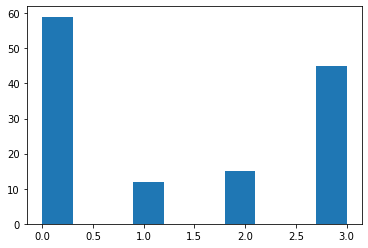

In [58]:
plt.hist(clinic_labels)
plt.show()

In [81]:
# train,test = train_test_split(labels, test_size=4, random_state=33) # , stratify=clinic_labels

In [87]:
test = ['n66', 'n70', 'n78', 'n15', 'n11', 'n5', 'G414', 'G258', 'G324']  #['38', '24', '1', '48', 'n15', 'n11', 'n5', 'G414', 'G258', 'G324']
train = labels.copy()

for rs in test:
    if rs in train:
        train.remove(rs)

In [88]:
len(test), len(train)

(9, 64)

In [89]:
metadata = {'train':train,
            'test':test}
np.save('metadata/metadata_fcd_nG.npy', metadata)